# Linear Regression

## Set up

In [2]:
using Distributions
using StatsBase
using Plots
using StatsPlots
using StatisticalRethinking

using CSV
using DataFrames

## Model for Height using Bayesian Inference (Grid Approximation)

$$ h \sim Normal(\mu,\sigma) $$

Compared to the globe tossing model, we have multiple data points here and multiple parameters, so we define a vector of data points $\bf{h}$ and vector of parameters $\theta$:

$$P(\theta | \bf{h}) = \frac{P(\bf{h}|\theta) \times P(\theta)}{P(\bf{h})}$$

where the denominator is the model evidence. It can be expressed as below, where $\theta$ can be integrated out of the expression 

$$P(\bf{h}) = \int_\theta{P(\bf{h}|\theta)P(\theta) d\theta} \approx \sum^ \theta{P(\bf{h}|\theta)P(\theta)}$$

### Priors and Prior Predictive Distribution

$$ \mu \sim Normal(178, 20) $$
$$ \sigma \sim Uniform(0,50)$$

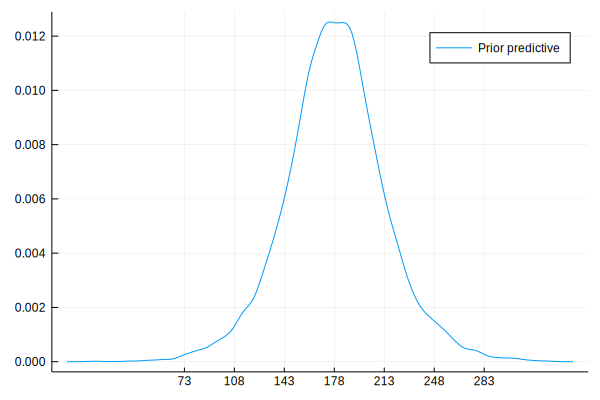

In [3]:
# sample each of the priors
prior_mean = Distributions.Normal(178, 20)
prior_stddev = Distributions.Uniform(0,50)
sample_mean = rand(prior_mean, 10000)
sample_stddev = rand(prior_stddev, 10000)

# construct prior predictive distribution using prior samples
prior_h = @.rand(Distributions.Normal(sample_mean, sample_stddev));
density(prior_h, label="Prior predictive")
xticks!(round(Int, mean(prior_h) - 3*std(prior_h)):
        round(Int, std(prior_h)):
        round(mean(prior_h) + 3*std(prior_h)))

This is a t-distribution, uncertainty about standard deviation results in long tails

### Loading and sampling data

In [4]:
data_path = StatisticalRethinking.rel_path("..", "data", "Howell1.csv")
howell_data = CSV.read(data_path)
describe(howell_data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,height,138.264,53.975,148.59,179.07,,,Float64
2,weight,35.6106,4.25242,40.0578,62.9926,,,Float64
3,age,29.3444,0.0,27.0,88.0,,,Float64
4,male,0.472426,0,0.0,1,,,Int64


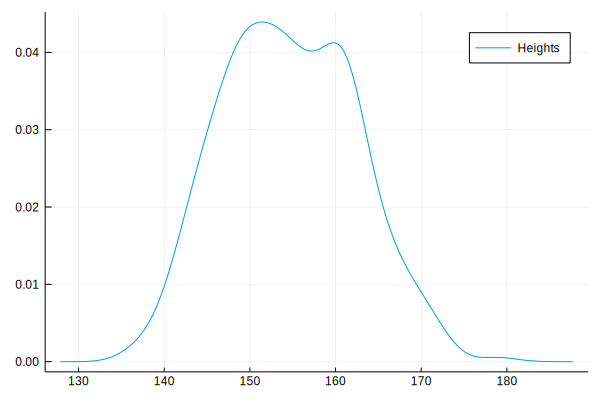

In [5]:
# filter for adult heights and then initliase parameter grids for grid approximation
adult_heights = howell_data[[i>=18 for i in howell_data[:, :age]],:height]
density(adult_heights, label="Heights")

### Calculating the posterior distribution

Create parameter grids and parameter matrix

In [6]:
μ_grid = range(140, stop=160, step=0.05)
σ_grid = range(4, stop=9, step=0.05)

# initialise parameter matrix
param_matrix = Matrix{Tuple}(undef, (length(σ_grid), length(μ_grid)))

# populate parameter matrix with grid values (x axis is μ and y axis is σ)
for x in 1:length(μ_grid)
    μ_value = μ_grid[x]
    for y in 1:length(σ_grid)
        σ_value = σ_grid[y]
        param_matrix[y, x] = (μ_value, σ_value)
    end
end
param_matrix

101×401 Array{Tuple,2}:
 (140.0, 4.0)   (140.05, 4.0)   …  (159.95, 4.0)   (160.0, 4.0) 
 (140.0, 4.05)  (140.05, 4.05)     (159.95, 4.05)  (160.0, 4.05)
 (140.0, 4.1)   (140.05, 4.1)      (159.95, 4.1)   (160.0, 4.1) 
 (140.0, 4.15)  (140.05, 4.15)     (159.95, 4.15)  (160.0, 4.15)
 (140.0, 4.2)   (140.05, 4.2)      (159.95, 4.2)   (160.0, 4.2) 
 (140.0, 4.25)  (140.05, 4.25)  …  (159.95, 4.25)  (160.0, 4.25)
 (140.0, 4.3)   (140.05, 4.3)      (159.95, 4.3)   (160.0, 4.3) 
 (140.0, 4.35)  (140.05, 4.35)     (159.95, 4.35)  (160.0, 4.35)
 (140.0, 4.4)   (140.05, 4.4)      (159.95, 4.4)   (160.0, 4.4) 
 (140.0, 4.45)  (140.05, 4.45)     (159.95, 4.45)  (160.0, 4.45)
 (140.0, 4.5)   (140.05, 4.5)   …  (159.95, 4.5)   (160.0, 4.5) 
 (140.0, 4.55)  (140.05, 4.55)     (159.95, 4.55)  (160.0, 4.55)
 (140.0, 4.6)   (140.05, 4.6)      (159.95, 4.6)   (160.0, 4.6) 
 ⋮                              ⋱                  ⋮            
 (140.0, 8.45)  (140.05, 8.45)     (159.95, 8.45)  (160.0, 8.45)
 

Compute likelihood distribution using parameter grid and data

Here there is multiple data. Given that each data point is an independent outcome, computing the likelihood of the dataset is the product of the likelihood calculation for each data point:

$$ P(\bf{h}| \theta) = \prod_{i=1}^n P(h_i| \theta)$$

In [7]:
# initialise posterior matrix and calculate posterior
posterior_matrix = Matrix{Float64}(undef, size(param_matrix))

# calculate likelihood by mapping Normal to each parameter tuple
# and then calculating the product of the probability densities for each data point
for i in CartesianIndices(size(param_matrix))
    μ = param_matrix[i][1]
    σ = param_matrix[i][2]
    posterior_matrix[i] = prod(pdf.(Distributions.Normal(μ, σ), adult_heights))
end
posterior_matrix

101×401 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

Since the likelihood is a product of likelihoods for each data point, the likelihood values are very small and being floored to zero. We can log Bayes rule to get:

$$\log{P(\theta | \bf{h})} = \log{P(\bf{h}|\theta)} + \log{P(\theta)} - \log{P(\bf{h})}$$

where

$$\log{P(\bf{h}\mid \theta}) = \log{\prod_{i=1}^n P(h_i \mid \theta)} = \sum_{i=1}^n \log{P(h_i \mid \theta)}$$

In [8]:
# calculate likelihood by mapping Normal to each parameter tuple
# and then calculating the sum of the logarithmic probability densities for each data point
for i in CartesianIndices(size(param_matrix))
    μ = param_matrix[i][1]
    σ = param_matrix[i][2]
    posterior_matrix[i] = sum(logpdf.(Distributions.Normal(μ, σ), adult_heights))
end

Calculate the unnormalised posterior using sum of log of likelihood and priors

In [9]:
for i in CartesianIndices(size(param_matrix))
    μ = param_matrix[i][1]
    σ = param_matrix[i][2]
    posterior_matrix[i] = posterior_matrix[i] + logpdf(prior_mean, μ) + logpdf(prior_stddev, σ)
end

We need to convert this back into probability. Going straight from a log, this will zero all values or cause rounding errors. Instead, we can scale by maximum log product to get likelihoods relative to the maximum. 

$$e^{\log{\bf{x}} - \log{x_{max}}} = \frac{\bf{x}}{x_{max}}$$

Note that this does not return probabilities, but relative posterior probabilities (i.e. $\sum{p} \neq 1$). Since we are looking at the region of MAP, this is OK

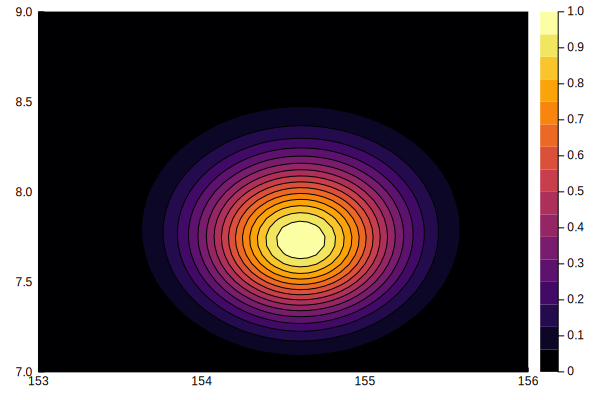

In [10]:
rel_post_prob = exp.(posterior_matrix .- maximum(posterior_matrix))
contour(μ_grid, σ_grid,rel_post_prob, fill=true)
xlims!((153,156))
ylims!((7,9))

### Sampling from the posterior

In [11]:
param_samples = DataFrame(
                          sample(reshape(param_matrix, :),
                                  Weights(reshape(rel_post_prob, :)),
                                  10000, replace=true)
                          )
rename!(param_samples, [:μ, :σ])
scatter(param_samples[!, :μ], param_samples[!, :σ], labels="samples")

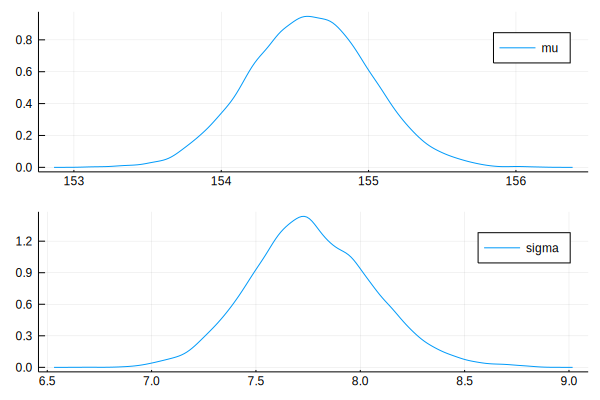

In [12]:
density(Array(param_samples), layout=(2,1), labels=["mu" "sigma"])

$\sigma$ is not symmetrical and Gaussian. Right tail is longer. Model knows stddev is positive - more uncertainty on the higher end as more large values consistent with data than smaller values

### Construct the posterior predictive

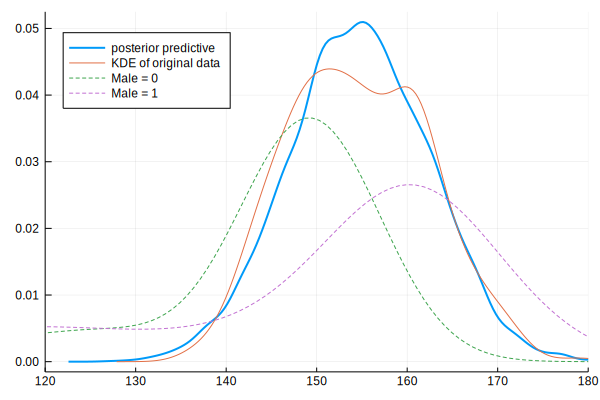

In [13]:
density(rand.(Distributions.Normal.(param_samples[!, :μ],
              param_samples[!, :σ])),
        label="posterior predictive",
        linewidth=2)
density!(adult_heights, label="KDE of original data")
@df howell_data density!(:height, group={Male=:male}, legend=:topleft, linestyle=:dash)
xlims!((120,180))

We lose the bimodal nature of the data in the model. The model does not account for the difference between the sexes

## Model for Height using Bayesian Inference (Quadratic Approximation)

In [14]:
using Stan
using StanSample

### Specify and run Stan model

In [15]:
# specify Stan model

height_model = "
data {
    // N data points, where h is greater than 0
    int N;
    real<lower=0> h[N];
}

parameters {
    // maximum height is 250, otherwise both params positive
    real<lower=0, upper=250> mu;
    real<lower=0> sigma;
}

model {
    // Priors
    mu ~ normal(178, 20);
    sigma ~ uniform(0,50);
    // Model for observed data
    h ~ normal(mu, sigma);
}
";

In [16]:
# instantiate model
sm = StanSample.SampleModel("height_model", height_model)
# prepare data vector for model input
N = length(adult_heights)
stan_data = Dict("N" => N, "h" => adult_heights)
rc = StanSample.stan_sample(sm, data=stan_data);


/tmp/tmpNNe0Tx/height_model.stan updated.


### Stan Results

In [17]:
if success(rc)
    chn = StanSample.read_samples(sm)
    chains_df = DataFrame(chn, append_chains=false)
    all_chains_df = DataFrame(chn)
    show(chn)
end

Object of type Chains, with data of type 1000×9×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = mu, sigma

2-element Array{ChainDataFrame,1}

Summary Statistics

│ Row │ parameters │ mean    │ std      │ naive_se   │ mcse       │ ess     │ r_hat   │
│     │ Symbol     │ Float64 │ Float64  │ Float64    │ Float64    │ Any     │ Any     │
├─────┼────────────┼─────────┼──────────┼────────────┼────────────┼─────────┼─────────┤
│ 1   │ mu         │ 154.615 │ 0.418381 │ 0.00661519 │ 0.00619004 │ 3513.76 │ 1.00049 │
│ 2   │ sigma      │ 7.77086 │ 0.29382  │ 0.00464571 │ 0.00622169 │ 2674.64 │ 1.00129 │

Quantiles

│ Row │ parameters │ 2.5%    │ 25.0%   │ 50.0%   │ 75.0%   │ 97.5%   │
│     │ Symbol     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼─────────┼─────────┼─────

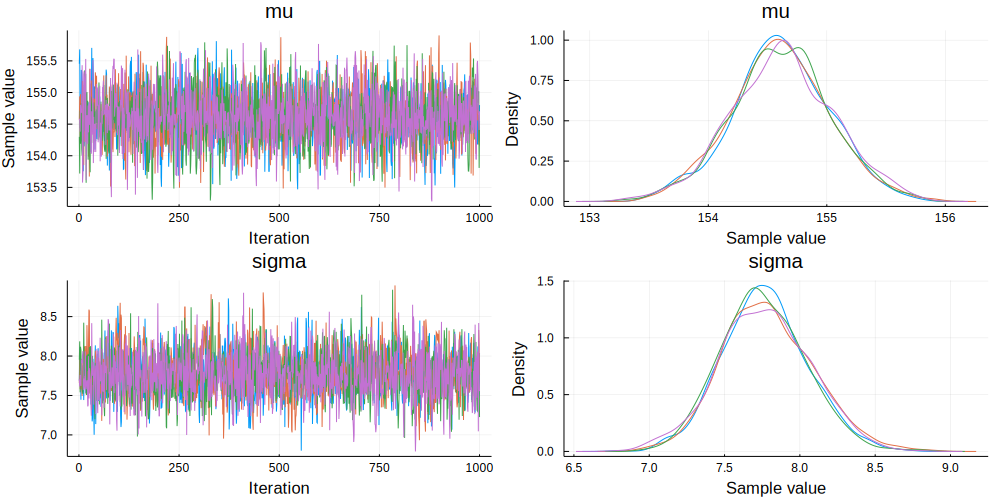

In [18]:
plot(chn)

### Quadratic Approximation

In [19]:
quap_fit = quap(all_chains_df);
p_mu = Particles(all_chains_df[:, :mu]);
p_sigma = Particles(all_chains_df[:, :sigma]);

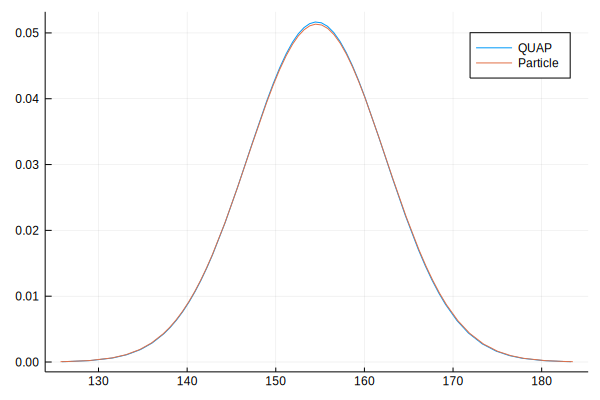

In [48]:
plot(Normal(mean(quap_fit[:mu]), mean(quap_fit[:sigma])), label="QUAP")
plot!(Normal(mean(p_mu), mean(p_sigma)), label="Particle")

## Regression Model for Height Predicted by Weight

The regression model states that the height is normally distributed, but that the mean of the normal distribution is specific for each row of data and is dependent upon the person's weight

$$h \sim Normal(\mu_i, \sigma)$$

where $\mu_i$ is related to the weight of the person, $x$,

$$\mu_i = \alpha + \beta(x_i-\bar{x})$$

Since $\alpha$ is the population mean when $x_i=\bar{x}$, we can use a prior for the population mean of the height
$$ \alpha \sim Normal(178,20) $$
Other priors:
$$ \beta \sim Normal(0,10)$$
$$\sigma \sim Uniform(0,50)$$

### Adult Data

In [29]:
adult_data = howell_data[[i>=18 for i in howell_data[:, :age]], :];

### Prior predictive distribution

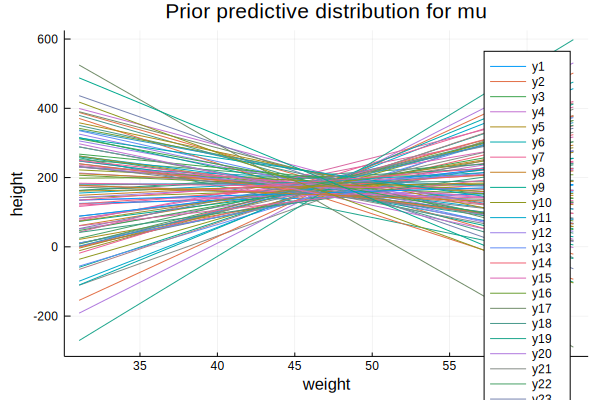

In [115]:
# sample priors 
N_prior = 100
α_prior = rand(Normal(178, 20), N_prior)
β_prior = rand(Normal(0, 10), N_prior)

μ_priors = []

# calculate mu across the range of weights from minimum to maximum in the sample
weight = collect(range(minimum(adult_data[:, :weight]), stop=maximum(adult_data[:, :weight]), length=N_prior))
μ_prior_plot = plot()
for i in 1:N_prior
    μ_prior = α_prior[i] .+ β_prior[i].*(weight .- mean(weight))
    plot!(weight, μ_prior)
end
xlabel!("weight")
ylabel!("height")
title!("Prior predictive distribution for mu")
μ_prior_plot

### Refining our prior for $\beta$ - Log-Normal

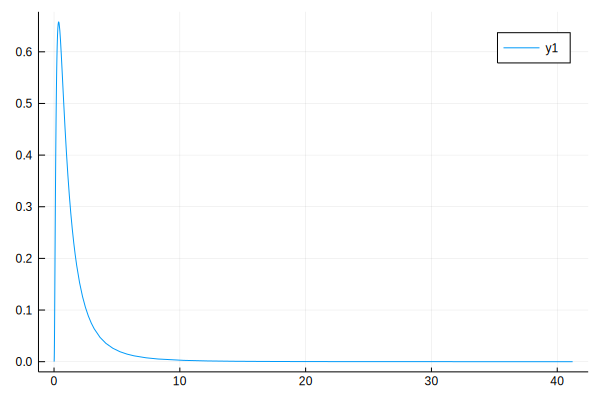

In [119]:
plot(LogNormal(0,1))

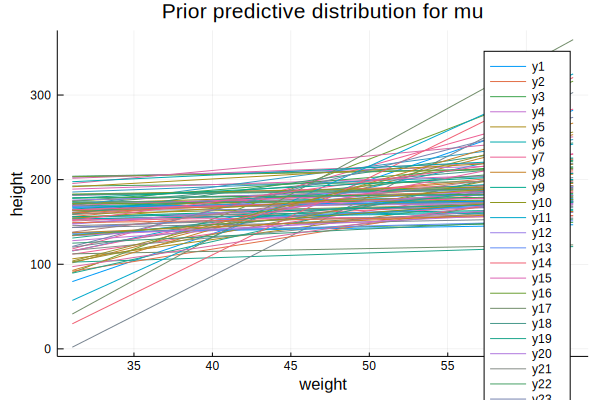

In [120]:
#change our value for β_prior
β_prior = rand(LogNormal(0,1), N_prior)

# calculate mu across the range of weights from minimum to maximum in the sample
weight = collect(range(minimum(adult_data[:, :weight]), stop=maximum(adult_data[:, :weight]), length=N_prior))
μ_prior_plot = plot()
for i in 1:N_prior
    μ_prior = α_prior[i] .+ β_prior[i].*(weight .- mean(weight))
    plot!(weight, μ_prior)
end
xlabel!("weight")
ylabel!("height")
title!("Prior predictive distribution for mu")
μ_prior_plot

### Sampling the posterior

#### Preparing inputs for Stan model

In [210]:
# inputs for Stan Model
N = length(height)

x = collect(adult_data[:, :weight])
x_bar = repeat([mean(x)], N)
centred_x = x - x_bar

height = collect(adult_data[:, :height])

regression_data = Dict("N" => N, "h" => height, "x" => centred_x)

Dict{String,Any} with 3 entries:
  "N" => 352
  "x" => [2.83512, -8.50468, -13.1256, 8.05143, -3.71361, 18.0021, -6.74701, 10…
  "h" => [151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 1…

In [289]:
# stan model
# for some reason, we ge a funny answer if we use the uniform prior
# model results are just as good as Rethinking without any priors
regression_model = "
data {
    int<lower=1> N;
    vector[N] h;
    vector[N] x;
}

parameters {
    real<lower=0> sigma;
    real  a;
    real b;
}

model {
    // priors
   a ~ normal(178, 20);
   //b ~ lognormal(0,1);
   // sigma ~ uniform(0,50);

    // regression
    h ~ normal(a + b * x, sigma);
}
";

#### Running Stan model

In [290]:
sm = StanSample.SampleModel("regression_weight_height", regression_model);


/tmp/tmpPDexRG/regression_weight_height.stan updated.


In [291]:
rc = stan_sample(sm, data=regression_data)
chn = StanSample.read_samples(sm)

Object of type Chains, with data of type 1000×10×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = sigma, a, b

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean    │ std       │ naive_se    │ mcse        │ ess     │
│     │ Symbol     │ Float64 │ Float64   │ Float64     │ Float64     │ Any     │
├─────┼────────────┼─────────┼───────────┼─────────────┼─────────────┼─────────┤
│ 1   │ sigma      │ 5.09884 │ 0.198132  │ 0.00313274  │ 0.00304536  │ 4112.6  │
│ 2   │ a          │ 154.599 │ 0.272911  │ 0.0043151   │ 0.00435067  │ 4055.95 │
│ 3   │ b          │ 0.90454 │ 0.0420484 │ 0.000664843 │ 0.000605843 │ 4043.5  │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%   │ 97.5%    │
│     │ Symbol     │ Float64  │ 

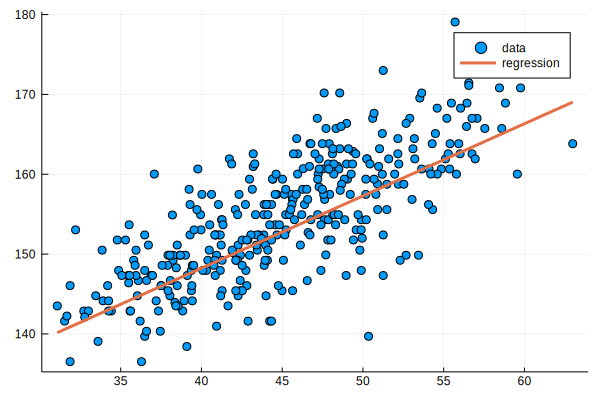

In [292]:
results = DataFrame(chn)
scatter(adult_data[:, :weight], adult_data[:, :height], label="data")
plot!(weight, 
      mean(results[:, :a]) .+ mean(results[:, :b]) .* (weight .- mean(weight)),
      label="regression", linewidth=3)